NEW MODEL

In [1]:
import pymc as pm
import numpy as np


In [2]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [3]:
data = load_data_from_json('data/sampled_intervention_0.json')

Data successfully loaded from data/sampled_intervention_0.json


In [4]:

graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

In [5]:

# Hypothèses : Tu as des données disponibles sous forme de matrices
# A, C, E : (100,)
# B, D : (100, 50)
"""
A = np.random.normal(0, 1, 100)
C = np.random.normal(0, 1, 100)
E = np.random.normal(0, 1, 100)

B_observed = np.random.normal(0, 1, (100, 50))
D_observed = np.random.normal(0, 1, (100, 50))
"""

a = np.array([data[f'a{i}'] for i in range(n_schools)])
c = np.array([data[f'c{i}'] for i in range(n_schools)])
e = np.array([data[f'e{i}'] for i in range(n_schools)])

# For b and d, we need to create 2D arrays
b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])




In [6]:
print(a)

[-0.77769207 -1.41234573 -1.92548352 -0.28381616 -2.28303415  1.08392033
  0.49213506  0.00350711 -2.40448874  0.98638752  0.56023335  1.17912826
  1.35183947 -0.04082827  0.83582457 -0.60449496 -0.45940528  1.47901415
  0.08801721 -0.10448975 -0.75012126 -0.05987282 -1.00823206  0.8052943
 -0.29526448 -1.98776202 -1.69252919 -0.52436288  0.23149813  0.26634744
  0.25585321  0.67245704 -0.7662639  -1.74393135  0.54816199  0.29357689
 -1.83610566  1.39127298  0.44982855 -0.08043862  0.82806887 -1.69170811
 -0.84481696 -0.78134242  0.10481826 -0.15596472 -1.65180685 -1.78940505
  0.74818465 -0.58864613]


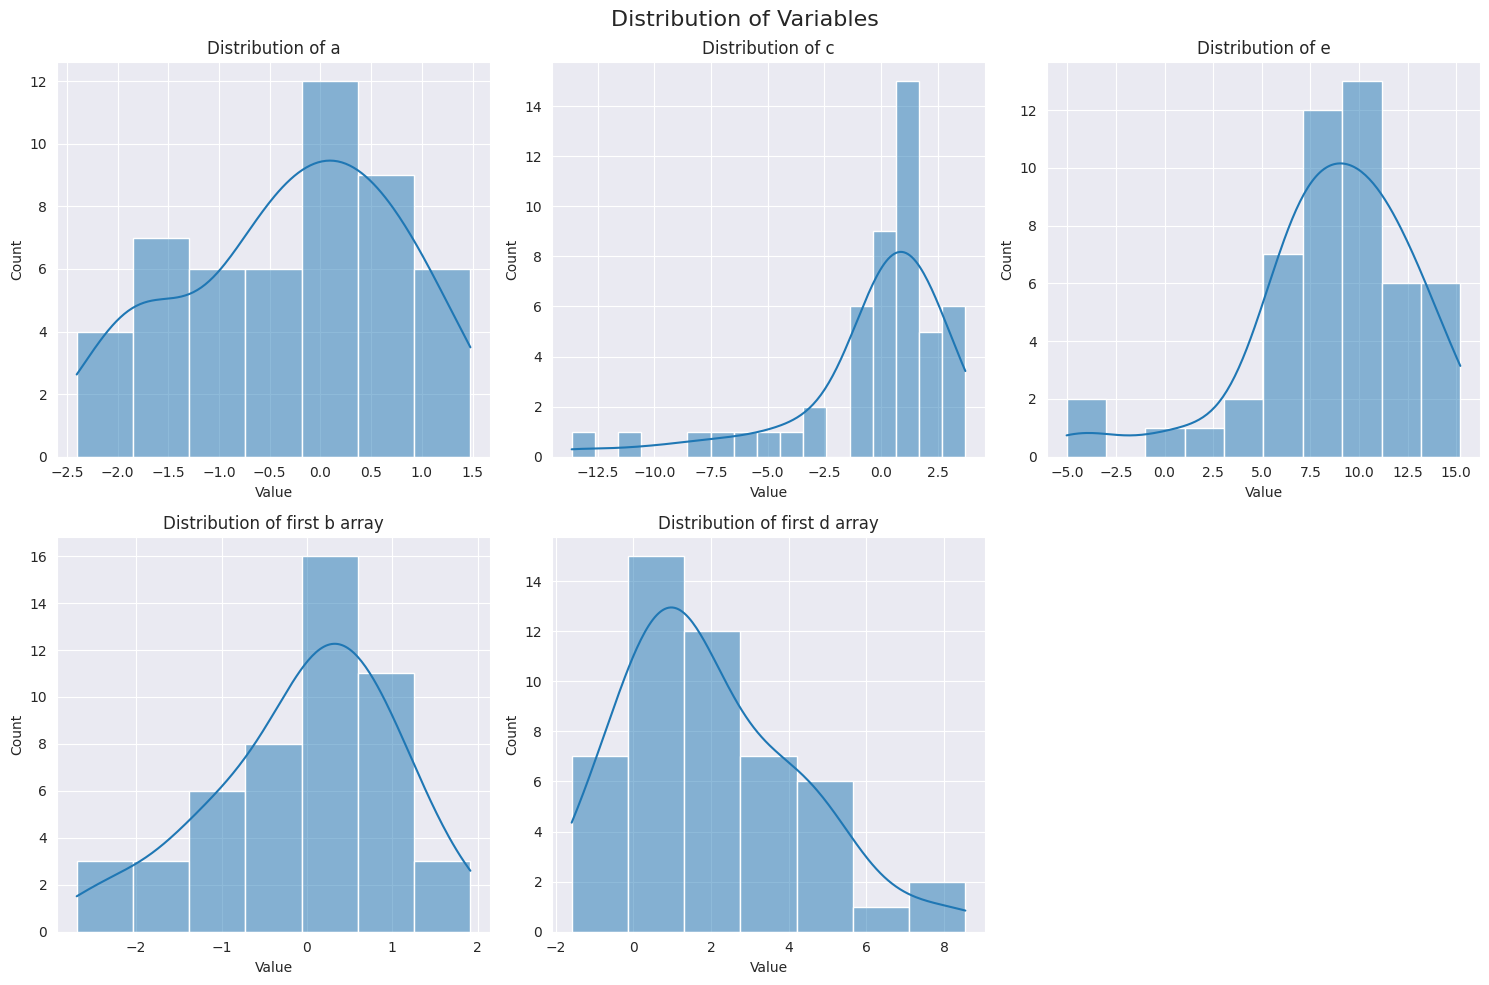

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Variables', fontsize=16)

# Plot distribution of a
sns.histplot(a, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of a')
axes[0, 0].set_xlabel('Value')

# Plot distribution of c
sns.histplot(c, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of c')
axes[0, 1].set_xlabel('Value')

# Plot distribution of e
sns.histplot(e, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of e')
axes[0, 2].set_xlabel('Value')

# Plot distribution of first b array
sns.histplot(b[0], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of first b array')
axes[1, 0].set_xlabel('Value')

# Plot distribution of first d array
sns.histplot(d[0], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of first d array')
axes[1, 1].set_xlabel('Value')

# Remove the unused subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


New model

In [8]:
print("Shape of a:", a.shape)
print("Shape of b:", b.shape)
print("Shape of c:", c.shape)
print("Shape of d:", d.shape)
print("Shape of e:", e.shape)


Shape of a: (50,)
Shape of b: (50, 50)
Shape of c: (50,)
Shape of d: (50, 50)
Shape of e: (50,)


In [9]:
with pm.Model() as model:
    # Niveau des écoles
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    mu_C = pm.Normal('mu_C', mu=0, sigma=1)
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    mu_E = pm.Normal('mu_E', mu=0, sigma=1)
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)

    # Niveau des élèves
    mu_B = pm.Normal('mu_B', mu=0, sigma=1)
    sigma_B = pm.HalfNormal('sigma_B', sigma=1)
    B_ij = pm.Normal('B_ij', mu=mu_B, sigma=sigma_B, observed=b)

    # Modèle pour le poids des élèves (D) en fonction des autres variables
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=1)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_E = pm.Normal('beta_E', mu=0, sigma=1)
    beta_B = pm.Normal('beta_B', mu=0, sigma=1)
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)

    mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij
    D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)

    # Inférence
    trace = pm.sample(50, return_inferencedata=True)

# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'mu_B', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, mu_B, sigma_B, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.269  0.164  -0.579    0.009      0.012    0.008     200.0     113.0   
mu_C   -0.278  0.455  -0.911    0.872      0.032    0.047     200.0      44.0   
mu_E    6.447  0.489   5.249    7.229      0.035    0.025     178.0     121.0   
mu_B   -0.014  0.019  -0.042    0.021      0.001    0.001     200.0     111.0   
alpha   1.448  0.118   1.245    1.696      0.014    0.010      64.0      77.0   
beta_A  0.108  0.051   0.016    0.197      0.005    0.004     103.0      80.0   
beta_C -0.097  0.021  -0.136   -0.066      0.003    0.002      69.0      81.0   
beta_E  0.062  0.013   0.043    0.085      0.002    0.001      80.0      77.0   
beta_B  2.021  0.033   1.966    2.089      0.002    0.002     200.0      41.0   

        r_hat  
mu_A     1.02  
mu_C     1.05  
mu_E     0.99  
mu_B     1.01  
alpha    1.02  
beta_A   1.03  
beta_C   1.04  
beta_E   1.02  
beta_B   1.00  


In [10]:
generated_data = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data['a'] = new_a

# c
mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
generated_data['c'] = new_c

# e
mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
generated_data['e'] = new_e


# Pour B
mu_B = trace.posterior['mu_B'].mean(dim=('chain', 'draw')).values
sigma_B = trace.posterior['sigma_B'].mean(dim=('chain', 'draw')).values
generated_data['b'] = np.random.normal(mu_B, sigma_B, size=(n_schools, n_students))

# Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values

# Calcul de mu_D
mu_D = (alpha + 
        beta_A * new_a[:, np.newaxis] + 
        beta_C * new_c[:, np.newaxis] + 
        beta_E * new_e[:, np.newaxis] + 
        beta_B * generated_data['b'])

generated_data['d'] = np.random.normal(mu_D, sigma_D)

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data[var].shape}")

print("Generated data:", generated_data)

Shape of generated a: (50,)
Shape of generated b: (50, 50)
Shape of generated c: (50,)
Shape of generated d: (50, 50)
Shape of generated e: (50,)
Generated data: {'a': array([-0.24231295,  0.31912423,  1.30463635,  1.63806828, -0.69419669,
       -0.67033326, -0.26393297, -2.64383809, -0.88912881, -0.78645396,
       -0.86316856,  1.43484786,  0.69249596,  0.42878695,  0.30908806,
       -2.76805699, -0.80728838,  0.85898246,  0.59856067, -0.73588792,
       -1.0418384 , -1.77597775, -0.1058697 ,  0.52832559, -0.98465194,
       -0.03291674,  1.94851421, -0.28895375, -1.98467592, -0.29155326,
       -1.77535677, -1.54805598, -0.36380127, -0.69549478, -1.09420241,
        1.02505775, -0.82615573,  0.54622554, -0.29277707, -0.19280237,
       -0.49838237,  1.15562874,  0.01244862,  0.93866977,  0.04748928,
       -1.16903984,  0.66768711,  0.64126743, -1.00369343,  0.12909405]), 'c': array([-4.58170923,  1.66889452, -4.39380808, -4.54450796, -5.55230022,
       -1.27441458,  3.55568899, 

In [11]:
from scipy.stats import gaussian_kde

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 1000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))

In [12]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.02649576294476399
KL divergence pour b: 0.001765835988074227
KL divergence pour c: 0.24659329409699404
KL divergence pour d: 0.17089911979236622
KL divergence pour e: 0.24587460683853804


---------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------- Avec intervention -------------------------------------------------------------------------------------------

------------------------------------------------------------

In [13]:
with pm.Model() as model:
    # Niveau des écoles
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    mu_C = pm.Normal('mu_C', mu=0, sigma=1)
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    mu_E = pm.Normal('mu_E', mu=0, sigma=1)
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)

    # B est maintenant une variable observée suivant une loi normale standard
    B_ij = pm.Normal('B_ij', mu=0, sigma=1, observed=b)

    # Modèle pour le poids des élèves (D) en fonction des autres variables
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=1)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_E = pm.Normal('beta_E', mu=0, sigma=1)
    beta_B = pm.Normal('beta_B', mu=0, sigma=1)
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)

    mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij
    D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)

    # Inférence
    trace = pm.sample(50, return_inferencedata=True)

# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 20 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.280  0.156  -0.570    0.020      0.013    0.012     171.0      57.0   
mu_C   -0.312  0.380  -0.926    0.325      0.031    0.026     170.0     108.0   
mu_E    6.504  0.566   5.573    7.726      0.041    0.031     177.0      99.0   
alpha   1.456  0.118   1.210    1.654      0.014    0.010      69.0      80.0   
beta_A  0.103  0.043   0.029    0.184      0.005    0.003      70.0     101.0   
beta_C -0.095  0.020  -0.131   -0.061      0.002    0.002      70.0      77.0   
beta_E  0.060  0.013   0.041    0.087      0.001    0.001      72.0      80.0   
beta_B  2.014  0.027   1.952    2.055      0.002    0.002     136.0     117.0   

        r_hat  
mu_A     1.00  
mu_C     1.01  
mu_E     0.99  
alpha    1.02  
beta_A   1.02  
beta_C   1.01  
beta_E   1.01  
beta_B   1.05  


In [14]:
generated_data_cond = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data_cond['a'] = new_a

# c
mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
generated_data_cond['c'] = new_c

# e
mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
generated_data_cond['e'] = new_e


# Pour B
generated_data_cond['b'] = np.random.normal(0, 1, size=(n_schools, n_students))

# Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values

# Calcul de mu_D
mu_D = (alpha + 
        beta_A * new_a[:, np.newaxis] + 
        beta_C * new_c[:, np.newaxis] + 
        beta_E * new_e[:, np.newaxis] + 
        beta_B * generated_data_cond['b'])

generated_data_cond['d'] = np.random.normal(mu_D, sigma_D)

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data_cond[var].shape}")

print("Generated data:", generated_data_cond)

Shape of generated a: (50,)
Shape of generated b: (50, 50)
Shape of generated c: (50,)
Shape of generated d: (50, 50)
Shape of generated e: (50,)
Generated data: {'a': array([-0.48410494,  0.03908847, -0.48390869,  0.58193916, -0.51110214,
        0.18586829, -0.58315166, -0.03948813,  0.6950833 , -1.32857093,
       -1.51102282, -0.04995565,  1.54291878,  0.72321745, -1.65915045,
       -3.31169161, -1.60546844, -0.98703453,  0.07701865,  0.89052103,
        0.1853135 , -2.32282892, -0.22479292, -0.40312103,  1.90654508,
       -0.42962509, -1.61452139,  0.08414871, -0.59185577, -1.43831582,
       -1.18756789, -0.8550945 , -1.55762957,  1.31508431,  1.484866  ,
        0.93927804,  2.06267377,  0.22139874,  0.25198971,  0.42947278,
       -0.90802015, -0.05822963,  1.80006217, -1.53290074,  1.14896215,
       -1.38873149, -1.71344949, -0.33708034, -0.65173436,  2.10841413]), 'c': array([-2.72314339, -1.32174616,  2.19453082,  0.68221657,  3.26640807,
       -0.09503457,  5.26721097, 

In [15]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data_cond[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.027253628173543442
KL divergence pour b: 0.003474880989831324
KL divergence pour c: 0.3252235438846276
KL divergence pour d: 0.21342469424741128
KL divergence pour e: 0.11966557991087438


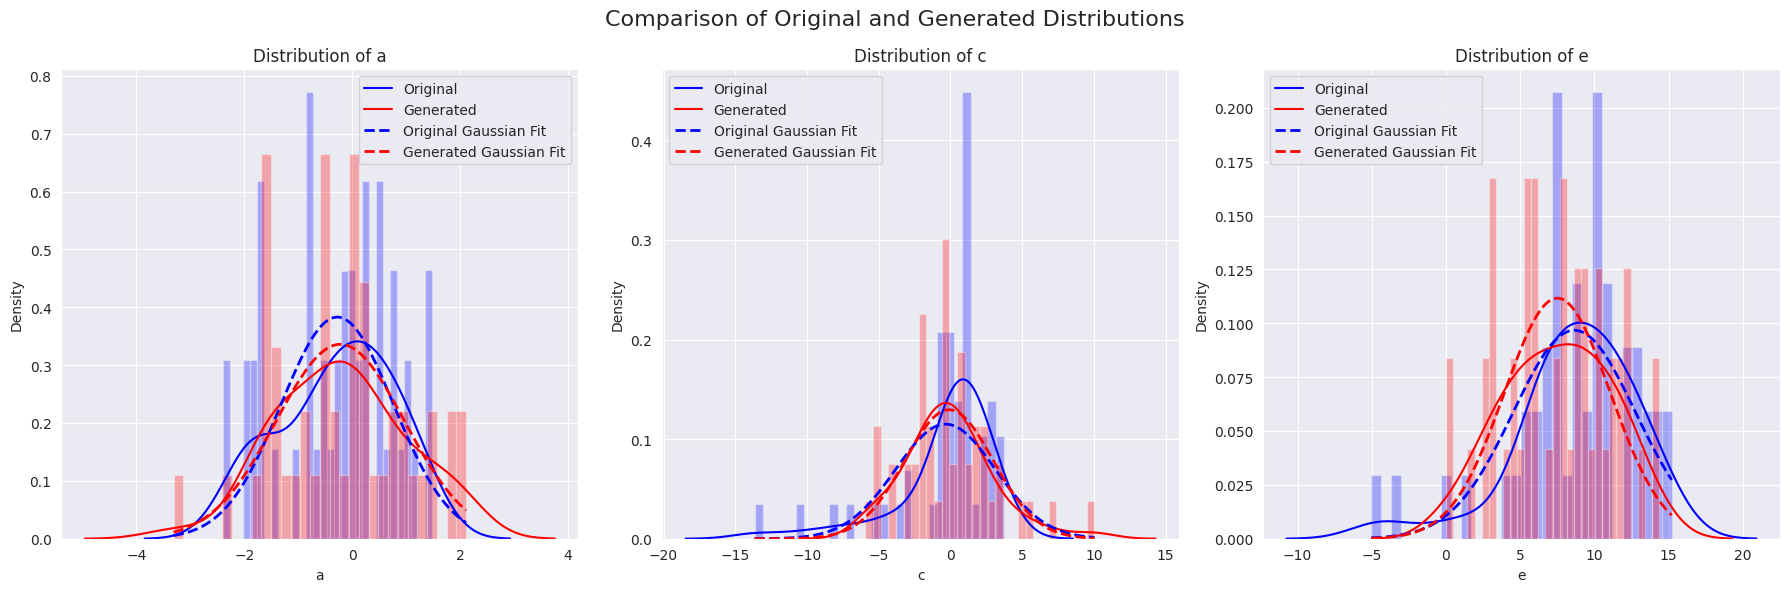

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Variables to plot
variables = ['a', 'c', 'e']

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparison of Original and Generated Distributions', fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i]
    
    # Original data
    original = eval(var)
    
    # Generated data
    generated = generated_data_cond[var]
    
    # KDE plot
    sns.kdeplot(original, ax=ax, label='Original', color='blue')
    sns.kdeplot(generated, ax=ax, label='Generated', color='red')
    
    # Histogram
    ax.hist(original, bins=30, alpha=0.3, color='blue', density=True)
    ax.hist(generated, bins=30, alpha=0.3, color='red', density=True)
    
    # Fit normal distribution
    mu_orig, std_orig = stats.norm.fit(original)
    mu_gen, std_gen = stats.norm.fit(generated)
    
    x = np.linspace(min(original.min(), generated.min()), 
                    max(original.max(), generated.max()), 100)
    
    ax.plot(x, stats.norm.pdf(x, mu_orig, std_orig), 
            'b--', linewidth=2, label='Original Gaussian Fit')
    ax.plot(x, stats.norm.pdf(x, mu_gen, std_gen), 
            'r--', linewidth=2, label='Generated Gaussian Fit')
    
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


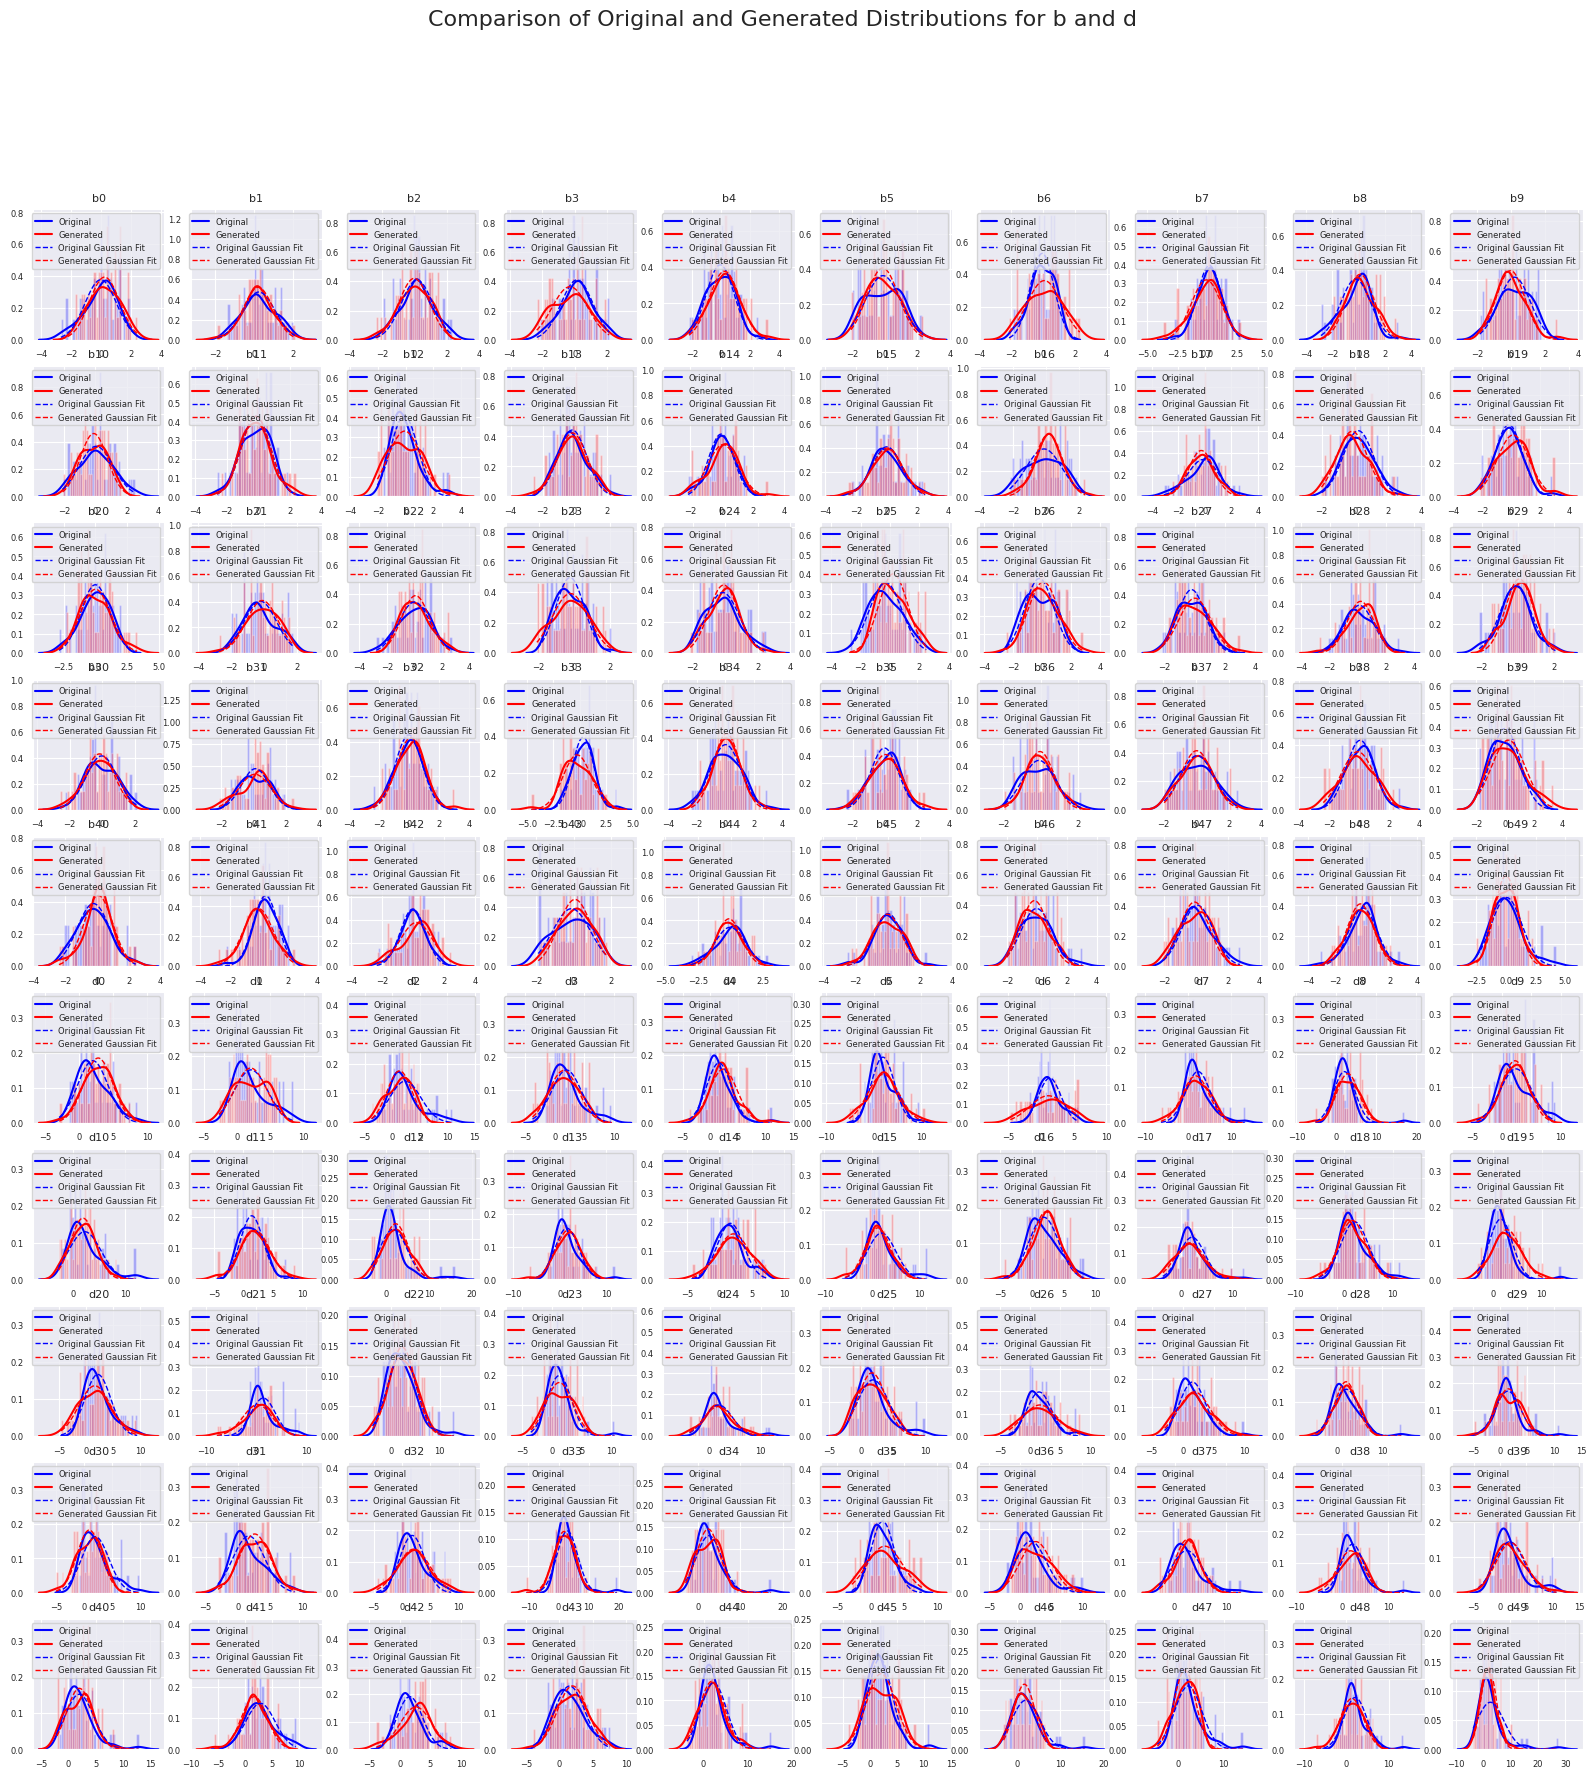

In [17]:
# Variables to plot
variables_bd = ['b', 'd']

# Set up the plot
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.suptitle('Comparison of Original and Generated Distributions for b and d', fontsize=16)

for i, var in enumerate(variables_bd):
    for j in range(50):
        ax = axes[5*i+j//10, j%10]
        
        # Original data
        original = eval(f'{var}')[j]
        
        # Generated data
        generated = generated_data_cond[f'{var}'][j]
        
        # KDE plot
        sns.kdeplot(original, ax=ax, label='Original', color='blue')
        sns.kdeplot(generated, ax=ax, label='Generated', color='red')
        
        # Histogram
        ax.hist(original, bins=30, alpha=0.3, color='blue', density=True)
        ax.hist(generated, bins=30, alpha=0.3, color='red', density=True)
        
        # Fit normal distribution
        mu_orig, std_orig = stats.norm.fit(original)
        mu_gen, std_gen = stats.norm.fit(generated)
        
        x = np.linspace(min(original.min(), generated.min()), 
                        max(original.max(), generated.max()), 100)
        
        ax.plot(x, stats.norm.pdf(x, mu_orig, std_orig), 
                'b--', linewidth=1, label='Original Gaussian Fit')
        ax.plot(x, stats.norm.pdf(x, mu_gen, std_gen), 
                'r--', linewidth=1, label='Generated Gaussian Fit')
        
        ax.set_title(f'{var}{j}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.legend(fontsize=6)

plt.show()


In [21]:
def experiment(n):
    all_kl_divs = []
    for k in range(n):
        data = load_data_from_json(f'data/sampled_intervention_{k}.json')
            
        a = np.array([data[f'a{i}'] for i in range(n_schools)])
        c = np.array([data[f'c{i}'] for i in range(n_schools)])
        e = np.array([data[f'e{i}'] for i in range(n_schools)])
        
        # For b and d, we need to create 2D arrays
        b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
        d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
        
        with pm.Model() as model:
            # Niveau des écoles
            mu_A = pm.Normal('mu_A', mu=0, sigma=1)
            sigma_A = pm.HalfNormal('sigma_A', sigma=1)
            A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)
        
            mu_C = pm.Normal('mu_C', mu=0, sigma=1)
            sigma_C = pm.HalfNormal('sigma_C', sigma=1)
            C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)
        
            mu_E = pm.Normal('mu_E', mu=0, sigma=1)
            sigma_E = pm.HalfNormal('sigma_E', sigma=1)
            E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)
        
            # B est maintenant une variable observée suivant une loi normale standard
            B_ij = pm.Normal('B_ij', mu=0, sigma=1, observed=b)
        
            # Modèle pour le poids des élèves (D) en fonction des autres variables
            alpha = pm.Normal('alpha', mu=0, sigma=1)
            beta_A = pm.Normal('beta_A', mu=0, sigma=1)
            beta_C = pm.Normal('beta_C', mu=0, sigma=1)
            beta_E = pm.Normal('beta_E', mu=0, sigma=1)
            beta_B = pm.Normal('beta_B', mu=0, sigma=1)
            sigma_D = pm.HalfNormal('sigma_D', sigma=1)
        
            mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij
            D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)
        
            # Inférence
            trace = pm.sample(50, return_inferencedata=True)
        
        # Résumé des résultats
        print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']), 'experiment', k)
        
        
        generated_data_cond = {}
        
        # a
        mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
        sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
        new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
        generated_data_cond['a'] = new_a
        
        # c
        mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
        sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
        new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
        generated_data_cond['c'] = new_c
        
        # e
        mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
        sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
        new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
        generated_data_cond['e'] = new_e
        
        
        # Pour B
        generated_data_cond['b'] = np.random.normal(0, 1, size=(n_schools, n_students))
        
        # Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
        alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
        beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
        beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
        beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
        beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
        sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values
        
        # Calcul de mu_D
        mu_D = (alpha + 
                beta_A * new_a[:, np.newaxis] + 
                beta_C * new_c[:, np.newaxis] + 
                beta_E * new_e[:, np.newaxis] + 
                beta_B * generated_data_cond['b'])
        
        generated_data_cond['d'] = np.random.normal(mu_D, sigma_D)
        
        kl_divs = {}
        
        for var in ['a', 'b', 'c', 'd', 'e']:
            original = eval(var)  # Les données originales
            generated = generated_data_cond[var]  # Les données générées
            
            # Pour b et d, nous devons aplatir les arrays 2D
            if var in ['b', 'd']:
                original = original.flatten()
                generated = generated.flatten()
            
            kl_divs[var] = kl_divergence(original, generated)
        
        all_kl_divs.append(kl_divs)
        

            
    

In [22]:
kl_divs = experiment(10)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_0.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 20 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.242  0.134  -0.468   -0.005      0.013    0.009     128.0      59.0   
mu_C   -0.327  0.442  -1.233    0.462      0.042    0.037     107.0      33.0   
mu_E    6.396  0.635   5.233    7.463      0.063    0.045     101.0      53.0   
alpha   1.485  0.113   1.265    1.691      0.013    0.009      83.0      85.0   
beta_A  0.098  0.051  -0.009    0.182      0.004    0.004     146.0      57.0   
beta_C -0.092  0.021  -0.133   -0.053      0.003    0.002      75.0      36.0   
beta_E  0.057  0.012   0.032    0.074      0.001    0.001      74.0      74.0   
beta_B  2.010  0.037   1.946    2.082      0.003    0.002     148.0      64.0   

        r_hat  
mu_A     0.99  
mu_C     1.04  
mu_E     1.02  
alpha    1.00  
beta_A   1.04  
beta_C   1.02  
beta_E   1.03  
beta_B   1.13   experiment 0
Data successfully loaded from data/sampled_intervention_1.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 22 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.045  0.121  -0.359    0.113      0.012    0.013     123.0      57.0   
mu_C    1.004  0.280   0.511    1.500      0.020    0.014     200.0      99.0   
mu_E    7.745  0.570   6.685    8.626      0.060    0.042      89.0     123.0   
alpha   1.546  0.127   1.327    1.777      0.013    0.009      93.0      80.0   
beta_A  0.079  0.063  -0.043    0.187      0.007    0.007      77.0      58.0   
beta_C -0.063  0.026  -0.103   -0.017      0.004    0.003      34.0      58.0   
beta_E  0.051  0.013   0.023    0.073      0.001    0.001      75.0     118.0   
beta_B  2.027  0.040   1.955    2.099      0.003    0.002     200.0      74.0   

        r_hat  
mu_A     1.00  
mu_C     0.99  
mu_E     0.98  
alpha    1.01  
beta_A   1.03  
beta_C   1.06  
beta_E   1.02  
beta_B   1.00   experiment 1
Data successfully loaded from data/sampled_intervention_2.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.047  0.157  -0.231    0.374      0.013    0.011     129.0     117.0   
mu_C    1.167  0.539   0.083    2.171      0.043    0.032     160.0      79.0   
mu_E    6.778  0.818   5.588    8.449      0.093    0.068      85.0      79.0   
alpha   1.613  0.158   1.350    1.913      0.029    0.021      31.0      25.0   
beta_A -0.096  0.060  -0.214    0.003      0.006    0.005      99.0      81.0   
beta_C -0.025  0.024  -0.064    0.023      0.004    0.003      32.0      52.0   
beta_E  0.041  0.016   0.009    0.068      0.003    0.002      34.0      25.0   
beta_B  2.036  0.040   1.969    2.115      0.004    0.003     112.0      48.0   

        r_hat  
mu_A     1.02  
mu_C     1.05  
mu_E     1.00  
alpha    1.05  
beta_A   1.00  
beta_C   1.05  
beta_E   1.04  
beta_B   1.01   experiment 2
Data successfully loaded from data/sampled_intervention_3.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 24 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.030  0.152  -0.302    0.222      0.011    0.013     176.0      77.0   
mu_C    1.263  0.315   0.552    1.746      0.041    0.032      57.0      54.0   
mu_E    7.771  0.646   6.574    8.892      0.072    0.051      83.0     112.0   
alpha   1.568  0.150   1.295    1.805      0.018    0.013      71.0      80.0   
beta_A  0.028  0.064  -0.115    0.125      0.007    0.006      89.0      38.0   
beta_C -0.074  0.028  -0.141   -0.032      0.003    0.002      81.0      55.0   
beta_E  0.058  0.016   0.034    0.090      0.002    0.001      77.0      98.0   
beta_B  2.002  0.032   1.954    2.065      0.002    0.002     200.0     121.0   

        r_hat  
mu_A     0.99  
mu_C     1.04  
mu_E     1.02  
alpha    1.00  
beta_A   1.06  
beta_C   1.01  
beta_E   1.03  
beta_B   1.02   experiment 3
Data successfully loaded from data/sampled_intervention_4.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 21 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.073  0.167  -0.366    0.208      0.012    0.018     200.0      72.0   
mu_C    0.923  0.497  -0.069    1.726      0.046    0.037     118.0     121.0   
mu_E    6.572  0.729   5.155    7.792      0.052    0.036     200.0      66.0   
alpha   1.311  0.095   1.174    1.527      0.009    0.007      99.0      79.0   
beta_A -0.019  0.076  -0.148    0.127      0.008    0.007     106.0      42.0   
beta_C -0.085  0.025  -0.141   -0.046      0.003    0.003      63.0      42.0   
beta_E  0.077  0.010   0.060    0.097      0.001    0.001      86.0      64.0   
beta_B  1.950  0.045   1.864    2.035      0.003    0.002     200.0      55.0   

        r_hat  
mu_A     1.01  
mu_C     1.00  
mu_E     1.04  
alpha    1.00  
beta_A   0.99  
beta_C   0.98  
beta_E   0.99  
beta_B   1.07   experiment 4
Data successfully loaded from data/sampled_intervention_5.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 22 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.004  0.146  -0.268    0.222      0.012    0.013     152.0      78.0   
mu_C    0.625  0.470  -0.347    1.300      0.033    0.024     200.0     107.0   
mu_E    7.488  0.610   6.251    8.571      0.051    0.036     146.0      47.0   
alpha   1.527  0.133   1.306    1.806      0.014    0.010      92.0     123.0   
beta_A  0.075  0.058  -0.049    0.162      0.005    0.004     116.0     117.0   
beta_C -0.076  0.023  -0.110   -0.024      0.002    0.002     106.0      78.0   
beta_E  0.051  0.014   0.025    0.076      0.002    0.001      84.0     120.0   
beta_B  1.978  0.040   1.903    2.051      0.003    0.002     200.0      78.0   

        r_hat  
mu_A     0.99  
mu_C     1.06  
mu_E     1.00  
alpha    1.00  
beta_A   0.99  
beta_C   1.01  
beta_E   1.00  
beta_B   1.02   experiment 5
Data successfully loaded from data/sampled_intervention_6.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 26 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.055  0.177  -0.351    0.338      0.020    0.014      86.0      79.0   
mu_C    0.788  0.609  -0.248    1.816      0.056    0.042     130.0      73.0   
mu_E    5.791  0.836   4.044    7.338      0.117    0.083      50.0      76.0   
alpha   1.410  0.125   1.169    1.628      0.016    0.012      59.0      89.0   
beta_A -0.024  0.050  -0.117    0.064      0.005    0.004     123.0      53.0   
beta_C -0.051  0.017  -0.085   -0.022      0.002    0.002      49.0      72.0   
beta_E  0.057  0.014   0.035    0.089      0.002    0.001      56.0     108.0   
beta_B  2.047  0.030   1.996    2.097      0.004    0.003      73.0      66.0   

        r_hat  
mu_A     1.06  
mu_C     1.04  
mu_E     1.05  
alpha    1.01  
beta_A   1.01  
beta_C   1.00  
beta_E   1.01  
beta_B   1.03   experiment 6
Data successfully loaded from data/sampled_intervention_7.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.065  0.162  -0.197    0.419      0.012    0.013     165.0      47.0   
mu_C    1.248  0.582   0.150    2.268      0.041    0.029     200.0      67.0   
mu_E    5.739  0.758   4.417    7.226      0.087    0.062      81.0      79.0   
alpha   1.338  0.127   1.113    1.566      0.020    0.014      42.0      55.0   
beta_A -0.015  0.041  -0.090    0.056      0.004    0.003      83.0      81.0   
beta_C -0.074  0.018  -0.106   -0.038      0.003    0.002      39.0      56.0   
beta_E  0.072  0.014   0.044    0.097      0.002    0.002      40.0      35.0   
beta_B  1.954  0.035   1.903    2.029      0.004    0.003     116.0      53.0   

        r_hat  
mu_A     1.00  
mu_C     1.05  
mu_E     1.02  
alpha    1.07  
beta_A   1.02  
beta_C   1.03  
beta_E   1.07  
beta_B   1.08   experiment 7
Data successfully loaded from data/sampled_intervention_8.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 24 seconds.
The number of samples is too small to check convergence reliably.
Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.055  0.167  -0.224    0.390      0.012    0.015     200.0      54.0   
mu_C    1.321  0.389   0.735    2.180      0.036    0.026     122.0      38.0   
mu_E    7.587  0.714   6.229    8.704      0.063    0.044     117.0     112.0   
alpha   1.413  0.154   1.210    1.810      0.017    0.012      80.0      81.0   
beta_A -0.051  0.050  -0.135    0.042      0.004    0.003     130.0      68.0   
beta_C -0.048  0.023  -0.095   -0.004      0.002    0.001     120.0     121.0   
beta_E  0.063  0.016   0.023    0.087      0.002    0.001      78.0      79.0   
beta_B  1.972  0.037   1.911    2.045      0.003    0.002     167.0      84.0   

        r_hat  
mu_A     0.99  
mu_C     1.10  
mu_E     1.02  
alpha    1.06  
beta_A   1.03  
beta_C   1.01  
beta_E   1.05  
beta_B   1.02   experiment 8
Data successfully loaded from data/sampled_intervention_9.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]


Output()

Output()

Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.098  0.154  -0.170    0.450      0.023    0.017      50.0      33.0   
mu_C    0.709  0.444  -0.266    1.494      0.042    0.032     105.0      42.0   
mu_E    6.324  0.596   5.253    7.493      0.063    0.045      90.0      92.0   
alpha   1.269  0.112   1.062    1.435      0.015    0.010      58.0      74.0   
beta_A -0.010  0.044  -0.086    0.076      0.004    0.004     125.0      81.0   
beta_C -0.078  0.017  -0.110   -0.046      0.003    0.002      46.0      61.0   
beta_E  0.076  0.012   0.059    0.101      0.002    0.001      61.0      74.0   
beta_B  1.896  0.043   1.816    1.959      0.005    0.004      78.0      79.0   

        r_hat  
mu_A     1.04  
mu_C     1.00  
mu_E     1.02  
alpha    1.01  
beta_A   1.02  
beta_C   1.02  
beta_E   1.00  
beta_B   1.02   experiment 9


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kldivs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kldivs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kldivs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


Garbage

In [ ]:
import numpy as np


def generate_causal_data(n_schools, n_students):
    data = {}

    # Generate a
    for i in range(n_schools):
        data[f'a{i}'] = np.random.normal(0, 1)

    # Generate b based on a
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_b{i}_{j}'] = (data[f'a{i}'] + 1) ** 2 + np.random.normal(0, 1)

    # Generate c based on a and b
    for i in range(n_schools):
        b_mean = np.mean([data[f'_b{i}_{j}'] for j in range(n_students)])
        data[f'c{i}'] = data[f'a{i}'] + (b_mean + 1) ** 2 + np.random.normal(0, 1)

    # Generate d based on b and c
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_d{i}_{j}'] = (data[f'_b{i}_{j}'] + 1) ** 2 + data[f'c{i}'] + np.random.normal(0, 0.5)

    # Generate e based on c and d
    for i in range(n_schools):
        d_mean = np.mean([data[f'_d{i}_{j}'] for j in range(n_students)])
        data[f'e{i}'] = data[f'c{i}'] + (d_mean + 1) ** 2 + np.random.normal(0, 1)

    return data


# Usage
n_schools = 10
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = generate_causal_data(n_schools, n_students)
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

# Example usage
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = {
    **{f'a{i}': i + 1 for i in range(n_schools)},
    **{f'c{i}': i + 5 for i in range(n_schools)},
    **{f'e{i}': i + 11 for i in range(n_schools)}
}

# Generate data for b and d
for i in range(n_schools):
    for j in range(n_students):
        data[f'_b{i}_{j}'] = 2 * i + j % 2 + 1  # This creates a slight variation between students
        data[f'_d{i}_{j}'] = 2 * i + j % 2 + 7  # This creates a slight variation between students



In [1]:
import networkx as nx
import numpy as np
from scipy.stats import norm, gaussian_kde
from scipy.integrate import quad
import pymc as pm


In [2]:
def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_'+var+str(i)+'_'+str(j)]
                data[var+str(i)] = s / self.sizes[i]
        return data

In [3]:

class HierarchicalBayesSampler:
    def __init__(self, graph, data, unit_vars, subunit_vars, sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.unit_vars = unit_vars
        self.subunit_vars = subunit_vars
        self.sizes = sizes
        self.processed_data = self.preprocess_data()
        
    def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_'+var+str(i)+'_'+str(j)]
                data[var+str(i)] = s / self.sizes[i]
        return data

    def generate(self):  # num_samples est maintenant 2
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + self.subunit_vars}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + self.subunit_vars}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # Priors pour les variables de niveau inférieur (sous-unités)
            subunit_variables = {}
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    subunit_variables[f'{var}{i}'] = pm.Normal(f'{var}{i}', mu=mu[var], sigma=sigma[var], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1, 
                        observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour les variables de niveau inférieur (sous-unités)
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    pm.Normal(f'obs_{var}{i}', 
                            mu=subunit_variables[f'{var}{i}'], 
                            sigma=1, 
                            observed=np.array([self.data[f'_{var}{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]  # Prend le premier (et seul) échantillon

        # Extraction et génération des sous-unités
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                generated_data[f'{var}{i}'] = trace[f'{var}{i}'][0]  # Prend le premier (et seul) échantillon

        return generated_data
    
    def generate_cond(self):
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors pour les autres variables
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + ['d']}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + ['d']}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # b est défini comme une variable observée suivant une loi normale standard
            b = pm.Normal('b', mu=0, sigma=1, shape=(len(self.sizes), max(self.sizes)), observed=np.random.normal(0, 1, (len(self.sizes), max(self.sizes))))

            # Priors pour les autres variables de niveau inférieur (d)
            subunit_variables = {}
            for i in range(len(self.sizes)):
                subunit_variables[f'd{i}'] = pm.Normal(f'd{i}', mu=mu['d'], sigma=sigma['d'], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1, 
                        observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour d
            for i in range(len(self.sizes)):
                pm.Normal(f'obs_d{i}', 
                        mu=subunit_variables[f'd{i}'], 
                        sigma=1, 
                        observed=np.array([self.data[f'_d{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]

        # Génération de b (toujours à partir d'une loi normale standard)
        for i in range(len(self.sizes)):
            generated_data[f'b{i}'] = np.random.normal(0, 1, size=self.sizes[i])

        # Extraction de d
        for i in range(len(self.sizes)):
            generated_data[f'd{i}'] = trace[f'd{i}'][0]

        return generated_data




In [7]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [8]:
data = load_data_from_json('data/sampled_data.json')

Data successfully loaded from data/sampled_data.json


In [9]:

graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

sampling

In [10]:

sampler = HierarchicalBayesSampler(graph, data, unit_vars, subunit_vars, sizes)


In [ ]:
generated_data = sampler.generate()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, mu_c, mu_e, mu_b, mu_d, sigma_a, sigma_c, sigma_e, sigma_b, sigma_d, a, c, e, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22, b23, b24, b25, b26, b27, b28, b29, b30, b31, b32, b33, b34, b35, b36, b37, b38, b39, b40, b41, b42, b43, b44, b45, b46, b47, b48, b49, d0, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22, d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, d35, d36, d37, d38, d39, d40, d41, d42, d43, d44, d45, d46, d47, d48, d49]


Output()

In [97]:
print( generated_data)


{'a': array([ 1.63065515,  1.7902874 ,  3.64379826,  4.20047022,  5.45190432,
        6.2507369 ,  7.24115763,  8.26437485, 10.2955575 , 10.88087505,
        9.52584466, 12.00288655, 14.51193756, 13.28003449, 14.05469803,
       13.87207749, 16.33657466, 19.49652471, 19.69615   , 19.35336748,
       19.77505565, 22.01298776, 23.0668964 , 24.23471286, 26.58541814,
       27.80412966, 27.22020489, 27.80914964, 29.2355082 , 29.61532339,
       29.50518518, 32.38111287, 32.66135276, 32.95779157, 35.86792962,
       36.30651974, 37.76048832, 39.49839915, 38.49655652, 39.32357128,
       38.85188431, 41.19294883, 41.18251028, 43.25409831, 45.93033013,
       45.32301705, 45.29567944, 47.19897617, 48.98364624, 50.2227248 ]), 'c': array([ 5.18359223,  6.57355743,  7.04102518,  6.76520866,  8.96573395,
        9.88228739, 11.62027158, 11.13115107, 13.83440859, 13.78365585,
       13.96381998, 16.57984348, 16.9390979 , 16.86406085, 20.5648649 ,
       19.55889189, 20.82874816, 20.15223973, 21.07

In [ ]:

generated_data_cond = sampler.generate_cond()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, mu_c, mu_e, mu_d, sigma_a, sigma_c, sigma_e, sigma_d, a, c, e, d0, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22, d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, d35, d36, d37, d38, d39, d40, d41, d42, d43, d44, d45, d46, d47, d48, d49]


Output()

Output()

In [ ]:
print(generated_data_cond)

In [ ]:
from scipy.stats import entropy

def kl_divergence(p, q):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Calculez les histogrammes des deux distributions
    bins = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 1000)
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_hist += epsilon
    q_hist += epsilon
    
    # Normalisez les histogrammes
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)
    
    # Calculez la divergence KL
    return entropy(p_hist, q_hist)


In [ ]:
# Compute KL divergence for 'e' variable
e_generated = generated_data['e']
e_original = np.array([sampler.processed_data[f'e{i}'] for i in range(len(sizes))])

e_generated_cond = generated_data_cond['e']




In [ ]:
kl_div = kl_divergence(e_original, e_generated)
print(f"KL divergence between original 'e' and generated 'e': {kl_div}")
kl_div_cond = kl_divergence(e_original, e_generated_cond)
print(f"KL divergence between original 'e' and generated 'e' with conditionning: {kl_div_cond}")


In [4]:
import numpy as np

In [5]:
import pymc as pm

In [21]:
import numpy as np

def generate_causal_data(n_schools, n_students):
    data = {}
    
    # Generate a
    for i in range(n_schools):
        data[f'a{i}'] =np.random.normal(0, 1)
    
    # Generate b based on a
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_b{i}_{j}'] = (data[f'a{i}']+1)**2 + np.random.normal(0, 1)
    
    # Generate c based on a and b
    for i in range(n_schools):
        b_mean = np.mean([data[f'_b{i}_{j}'] for j in range(n_students)])
        data[f'c{i}'] = data[f'a{i}'] +(b_mean+1)**2 + np.random.normal(0, 1)
    
    # Generate d based on b and c
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_d{i}_{j}'] = (data[f'_b{i}_{j}']+1)**2 +data[f'c{i}'] + np.random.normal(0, 0.5)
    
    # Generate e based on c and d
    for i in range(n_schools):
        d_mean = np.mean([data[f'_d{i}_{j}'] for j in range(n_students)])
        data[f'e{i}'] = data[f'c{i}'] + (d_mean+1)**2 + np.random.normal(0, 1)
    
    return data

# Usage
n_schools = 50
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = generate_causal_data(n_schools, n_students)